In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [5]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00


Sliding window for training and testing over multiple iterations

In [68]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

In [69]:
data = pd.read_csv('/content/drive/MyDrive/TSA_BDA_2024/Lab4/Retail_sales_of_electricity_United_States_monthly.csv', skiprows=4)

In [70]:
data.dropna(inplace=True)
data['DatePart'] = pd.to_datetime(data['Month'], format='%b %Y', errors='coerce')
data.rename(columns = {"DatePart" : "Date"}, inplace=True)
data.set_index("Date", inplace=True)
data.drop(columns=["Month"], inplace=True)

All sectors electricity data:

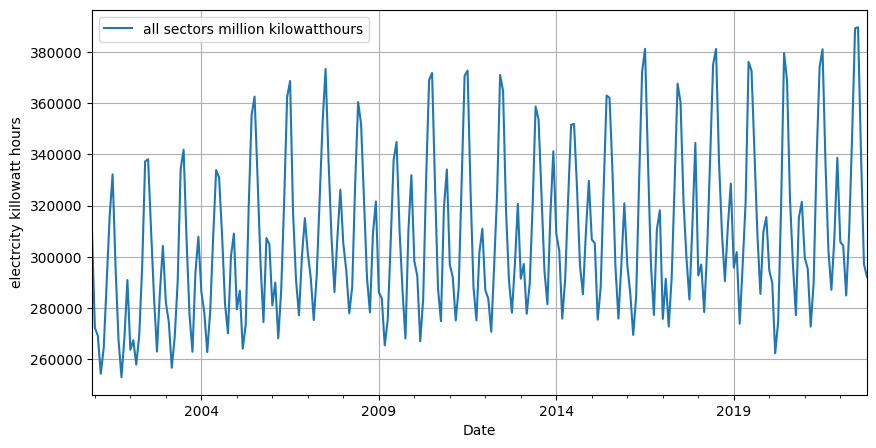

In [71]:
data.plot(figsize=(10,5), grid=True)
plt.ylabel("electrcity killowatt hours")
plt.show()

In [72]:
data.sort_index(inplace=True)
data

,all sectors million kilowatthours
Date,
2000-12-01,310816.06880
2001-01-01,272334.73804
2001-02-01,269298.40142
2001-03-01,254390.93545
2001-04-01,264490.49166
...,...
2022-06-01,389214.17473
2022-07-01,389626.28230
2022-08-01,340543.84071


using auto_arima for automatically selecting the optimal ARIMA model parameters for a given time series dataset

In [73]:
auto_arima(data["all sectors million kilowatthours"], seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  263
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood               -2675.909
Date:                             Tue, 23 Apr 2024   AIC                           5357.818
Time:                                     22:20:25   BIC                           5368.395
Sample:                                 12-01-2000   HQIC                          5362.074
                                      - 10-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1707.6753    634.656      2.691      0.007     463.773    2951.577
ma.L1          0.1343      0.008     16.693      0.000       0.119       0.150
sigma2      8.528e+07      0.001   1.54e+11      0.000    8.53e+07    8.53e+07
===================================================================================
Ljung-Box (L1) (Q):                  52.99   Jarque-Bera (JB):                76.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.56
Prob(H) (two-sided):                  0.54   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.71e+27. Standard errors may be unstable.
"""

Using autoarima we see that are model to be used is a purely moving average model with auto regressive and diff paramters are 0

so we will move forard with that in our sliding window iterations

In [76]:
data.index.freq='MS'

single iteration, training on entire data and testing on last 12 months

In [77]:
X_train= data.iloc[:-12]
X_test= data.iloc[-12:]
start = len(X_train)
end = start + len(X_test) -1

In [78]:
model = SARIMAX(X_train["all sectors million kilowatthours"], order=(0,0,1), seasonal_order=(0,1,0,12))
fit = model.fit()
pred = fit.predict(start, end).rename("SARIMA (0,0,1) (0,0,1,12)")
map = mean_absolute_percentage_error(X_test, pred) * 100

<Axes: xlabel='Date'>

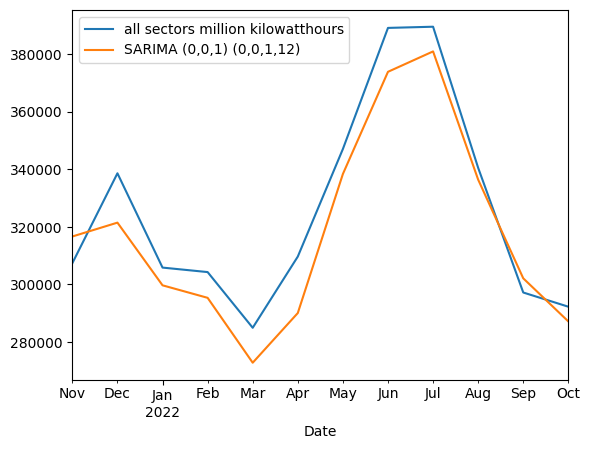

In [79]:
ax=X_test.plot(legend=True, label="Test")
pred.plot(legend=True)

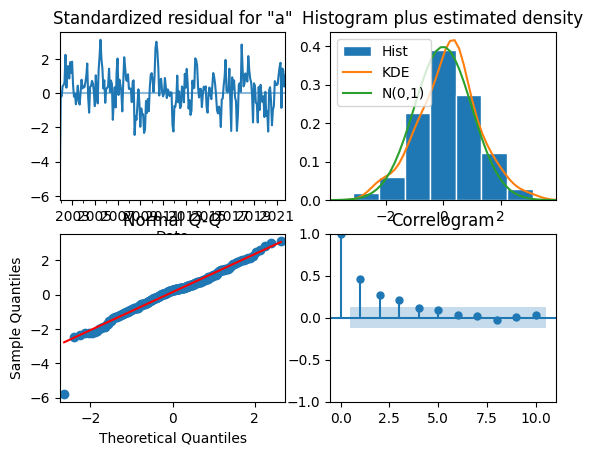

In [80]:
fit.plot_diagnostics();

In [67]:
print(f"Mean absolute percentage error : {map}")

Mean absolute percentage error : 3.074995032564922


From the plot diagnostics we see we still have some corelations

Sliding window iterations

In [81]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.simplefilter('ignore', ConvergenceWarning)

In [82]:
num_repeats = 30
length = len(data)
min_train_points = 70
move_window_by = 6

In [102]:
min_map = float('inf')
best_fit = None
preds = None
test = None
maps = []

In [103]:
for j in range(num_repeats):
    train_window_start = j * move_window_by
    train_window_end = min(train_window_start + min_train_points, length)
    test_window_start = train_window_end
    test_window_end = min(test_window_start + 12, length)
    X_train = data[train_window_start:train_window_end]
    X_test = data[test_window_start:test_window_end]
    start = len(X_train)
    end = start + len(X_test) - 1
    model = SARIMAX(X_train["all sectors million kilowatthours"], order=(0,0,1), seasonal_order=(0,1,0,12))
    fit = model.fit()
    pred = fit.predict(start, end).rename("SARIMA (0,0,1) (0,0,1,12)")
    map = mean_absolute_percentage_error(X_test, pred) * 100
    maps.append(map)
    if map < min_map:
        min_map = map
        best_fit = fit

print(f"Minimum Mean Absolte Percentage Error in {num_repeats} repitions: {min_map} \n\n")
print(f"Average Mean Absolte Percentage Error over {num_repeats} repitions: {np.mean(maps)} \n\n")
print("Best Fit Model:", best_fit.summary())


Minimum Mean Absolte Percentage Error in 30 repitions: 1.076937412196792 


Average Mean Absolte Percentage Error over 30 repitions: 2.670455567882387 


Best Fit Model:                                        SARIMAX Results                                       
Dep. Variable:     all sectors million kilowatthours   No. Observations:                   70
Model:               SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -628.443
Date:                               Tue, 23 Apr 2024   AIC                           1260.886
Time:                                       22:31:17   BIC                           1265.007
Sample:                                   12-01-2004   HQIC                          1262.491
                                        - 09-01-2010                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]

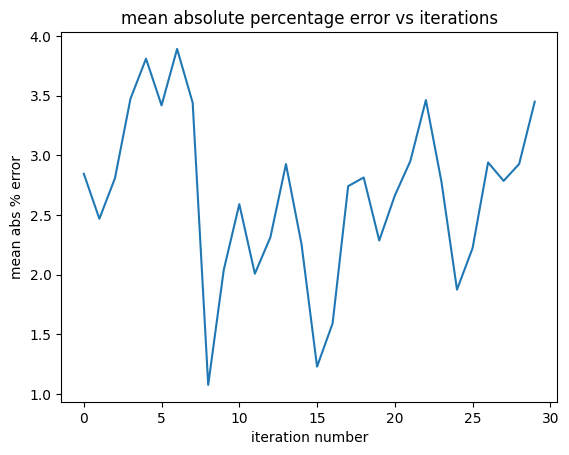

In [106]:
plt.plot(range(num_repeats),maps)
plt.title("mean absolute percentage error vs iterations")
plt.xlabel("iteration number")
plt.ylabel("mean abs % error")
plt.show()

PLOT DIAGNOSTICS OF THE BEST FIT: ( best fit according to lowest mean abs% error value)

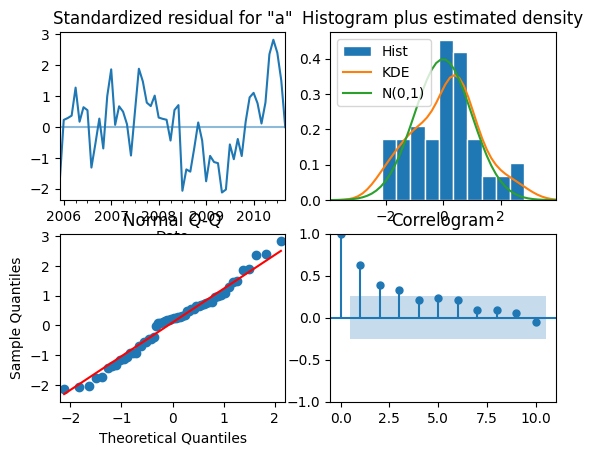

In [92]:
best_fit.plot_diagnostics();

samples vs theoretical Quantiles plot is a straight line . nearing origin
Ideally, the points should fall along the diagonal line, indicating that the residuals are normally distributed.

Significant autocorrelation at certain lags here may suggest that the model is not fully capturing our dependencies in the data

The sliding window model is more like the the real-world scenario where the model needs to make predictions sequentially over time. It provides a better evaluation of the model's performance compared to training on all data at once